# Link prediction
- Goals
    - Transform graph to vector and build a model through node2vector(graph vector).
    - Remove some links and test if the real link can be predicted or not.
- Simplify from the following website.
    - https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/

## Import packages

In [1]:
# !pip install -U gensim

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from node2vec import Node2Vec

## Load data

In [2]:
df = pd.read_csv('./data/fb_edgedf.csv', dtype='object')
df

node_1 node_2
0         0    276
1         0     58
2         0    132
3         0    603
4         0    398
...     ...    ...
2097    597    611
2098    601    603
2099    601    616
2100    603    616
2101    311    613

[2102 rows x 2 columns]

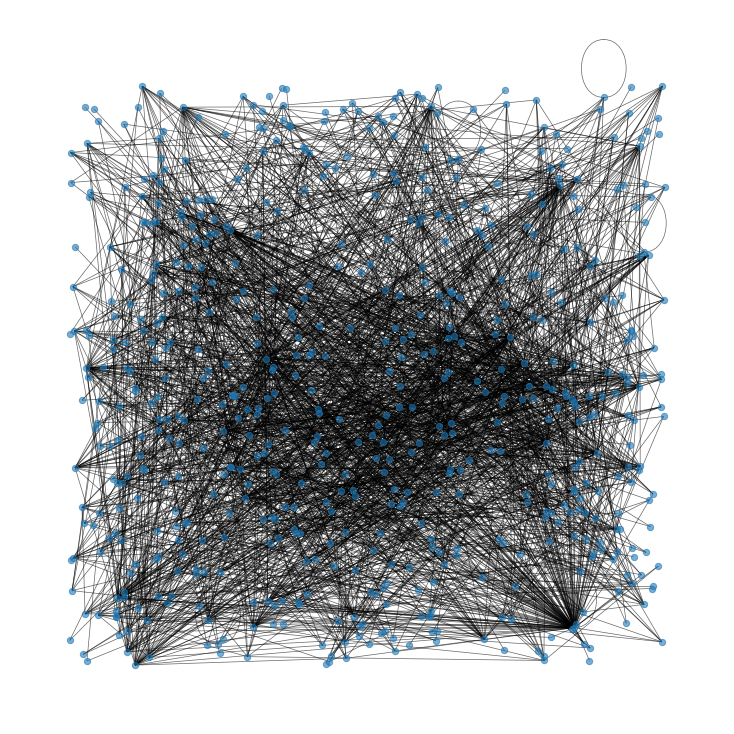

In [3]:
# create graph
G = nx.from_pandas_edgelist(df, 'node_1', 'node_2', create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [4]:
nx.to_pandas_adjacency(G)

0  276   58  132  603  398  555    1  265  611  ...  579  511  513  \
0    0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
276  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
58   1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  ...  0.0  0.0  0.0   
132  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
603  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
586  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
541  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
551  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
219  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
556  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     592  573  586  541  551  219  556  
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
276  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
58   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
132  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
603  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
..   ...  ...  ...  ...  ...  ...  ...  
586  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
541  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
551  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
219  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
556  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[620 rows x 620 columns]

## Add noises to test goal 2
- Goal 2: Remove some links

In [5]:
df = nx.to_pandas_adjacency(G).stack().reset_index(name = 'link')
df.columns = ['node_1', 'node_2', 'link']
df

node_1 node_2  link
0           0      0   0.0
1           0    276   1.0
2           0     58   1.0
3           0    132   1.0
4           0    603   1.0
...       ...    ...   ...
384395    556    586   0.0
384396    556    541   0.0
384397    556    551   0.0
384398    556    219   0.0
384399    556    556   1.0

[384400 rows x 3 columns]

In [6]:
# Due to it is an undirected Graph, we can remove duplicate data 
df['min_node'] = df.apply(lambda x: min([x['node_1'], x['node_2']]), axis=1)
df['max_node'] = df.apply(lambda x: max([x['node_1'], x['node_2']]), axis=1)
df = df.drop_duplicates(['min_node', 'max_node'])
df = df.drop(['node_1', 'node_2'], axis=1).rename(columns={'min_node':'node_1', 'max_node':'node_2'})
df

link node_1 node_2
0        0.0      0      0
1        1.0      0    276
2        1.0      0     58
3        1.0      0    132
4        1.0      0    603
...      ...    ...    ...
383158   0.0    219    551
383159   0.0    551    556
383778   0.0    219    219
383779   0.0    219    556
384399   1.0    556    556

[192510 rows x 3 columns]

In [7]:
# Sample 100 real links and remove them.
df2 = df.loc[df['link']==1].sample(n=100, random_state=32)
df2['mis_link'] = 1-df2['link']
df2

link node_1 node_2  mis_link
5764     1.0     32    611       0.0
86402    1.0    208    343       0.0
42694    1.0    229    396       0.0
25200    1.0    256    518       0.0
7310     1.0    182    246       0.0
...      ...    ...    ...       ...
66926    1.0    353    374       0.0
99373    1.0     31     48       0.0
59128    1.0    439     70       0.0
165809   1.0     47    500       0.0
41059    1.0    340    343       0.0

[100 rows x 4 columns]

In [8]:
# Replace original data
for node_1, node_2, mis_link in zip(df2['node_1'], df2['node_2'], df2['mis_link']):
    df.loc[(df['node_1']==node_1) & (df['node_2']==node_2), 'link'] = mis_link
df

link node_1 node_2
0        0.0      0      0
1        1.0      0    276
2        1.0      0     58
3        1.0      0    132
4        1.0      0    603
...      ...    ...    ...
383158   0.0    219    551
383159   0.0    551    556
383778   0.0    219    219
383779   0.0    219    556
384399   1.0    556    556

[192510 rows x 3 columns]

## Node to vector

In [9]:
# build graph
G_data = nx.from_pandas_edgelist(df = df.loc[df['link']==1], 
                                 source='node_1',
                                 target='node_2',
                                 create_using=nx.Graph())

In [10]:
# Generate walks
node2vec = Node2Vec(G_data, dimensions=10, walk_length=16, num_walks=50, workers=1)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/615 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.98it/s]


In [11]:
def get_vector(model, node1, node2):
    try:
        return model.wv[node1] - model.wv[node2]
    except:
        return None

In [12]:
df['n2v'] = df.apply(lambda x: get_vector(model=n2w_model, node1=x['node_1'], node2=x['node_2']), axis=1)
df = df.loc[df['n2v'].notnull()]
df

link node_1 node_2                                                n2v
0        0.0      0      0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        1.0      0    276  [-0.17461002, 0.91015303, 0.109879166, -0.8141...
2        1.0      0     58  [-0.438668, -0.40208608, -0.0223172, 0.4003611...
3        1.0      0    132  [-0.1428048, -0.5886452, 0.07508889, 0.2317707...
4        1.0      0    603  [-0.5137745, -0.8664939, 0.09227827, 0.5327906...
...      ...    ...    ...                                                ...
383158   0.0    219    551  [-0.2742735, 0.35268664, 0.35603106, -2.623732...
383159   0.0    551    556  [-0.024497628, -0.3653903, -0.7668239, 2.71481...
383778   0.0    219    219  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
383779   0.0    219    556  [-0.29877114, -0.012703657, -0.41079283, 0.091...
384399   1.0    556    556  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[189420 rows x 4 columns]

## Building Models

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array([wv for wv in df['n2v']]),
                                                df['link'], 
                                                test_size = 0.2, 
                                                random_state = 32)

### LR

In [14]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced')

In [15]:
predictions = lr.predict_proba(xtest)
roc_auc_score(ytest, predictions[:,1])

0.5389892073629879

### Light GBM

In [16]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=10)

/home/tlyu0419/github/envs/env/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1640, number of negative: 149896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 151536, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010823 -> initscore=-4.515245
[LightGBM] [Info] Start training from score -4.515245
[1]	valid_0's auc: 0.941236
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.95697
[3]	valid_0's auc: 0.96383
[4]	valid_0's auc: 0.966791
[5]	valid_0's auc: 0.967541
[6]	valid_0's auc: 0.966828
[7]	valid_0's auc: 0.967859
[8]	valid_0's auc: 0.969016
[9]	valid_0's auc: 0.97044
[10]	valid_0's auc: 0.970845
[11]	valid_0's auc: 0.971452
[12]	valid_0's auc: 0.97228
[13]	valid_0's auc: 0.973013
[14]	valid_0'

## Finding

### Finding 1: node2vector(graph vector) is an excellent method to generate valuable features!

### Finding 2: Real link can be predicted soundly.

In [17]:
df['pred_link'] = model.predict(np.array([wv for wv in df['n2v']]))
df['pred_link'] = df['pred_link'].apply(lambda x: int(x>=0.5))
df

/tmp/ipykernel_5328/3669671230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_link'] = model.predict(np.array([wv for wv in df['n2v']]))
/tmp/ipykernel_5328/3669671230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_link'] = df['pred_link'].apply(lambda x: int(x>=0.5))


link node_1 node_2                                                n2v  \
0        0.0      0      0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1        1.0      0    276  [-0.17461002, 0.91015303, 0.109879166, -0.8141...   
2        1.0      0     58  [-0.438668, -0.40208608, -0.0223172, 0.4003611...   
3        1.0      0    132  [-0.1428048, -0.5886452, 0.07508889, 0.2317707...   
4        1.0      0    603  [-0.5137745, -0.8664939, 0.09227827, 0.5327906...   
...      ...    ...    ...                                                ...   
383158   0.0    219    551  [-0.2742735, 0.35268664, 0.35603106, -2.623732...   
383159   0.0    551    556  [-0.024497628, -0.3653903, -0.7668239, 2.71481...   
383778   0.0    219    219  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
383779   0.0    219    556  [-0.29877114, -0.012703657, -0.41079283, 0.091...   
384399   1.0    556    556  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

        pred_link  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
383158          0  
383159          0  
383778          1  
383779          1  
384399          1  

[189420 rows x 5 columns]

In [18]:
result = pd.merge(df2, df.loc[:, ['node_1','node_2', 'pred_link']], how='inner', on = ['node_1','node_2'])
result

link node_1 node_2  mis_link  pred_link
0    1.0     32    611       0.0          1
1    1.0    208    343       0.0          1
2    1.0    256    518       0.0          0
3    1.0    182    246       0.0          1
4    1.0    242    498       0.0          0
..   ...    ...    ...       ...        ...
90   1.0    353    374       0.0          1
91   1.0     31     48       0.0          1
92   1.0    439     70       0.0          1
93   1.0     47    500       0.0          0
94   1.0    340    343       0.0          1

[95 rows x 5 columns]

In [19]:
result.groupby(['link', 'pred_link']).size()

link  pred_link
1.0   0            37
      1            58
dtype: int64

In [21]:
58/95

0.6105263157894737